# A Basic Model
In this example application it is shown how a simple time series model can be developed to simulate groundwater levels. The recharge (calculated as preciptation minus evaporation) is used as the explanatory time series.

In [1]:
# First perform the necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
%matplotlib inline

### 1. Importing the dependent time series data
In this codeblock a time series of groundwater levels is imported using the `read_csv` function of `pandas`. As `pastas` expects a `pandas` `Series` object, the data is squeezed. To check if you have the correct data type (a `pandas Series` object), you can use `type(oseries)` as shown below. 

The following characteristics are important when importing and preparing the observed time series:
- The observed time series are stored as a `pandas Series` object.
- The time step can be irregular.

The data type of the oseries is: <class 'pandas.core.series.Series'>


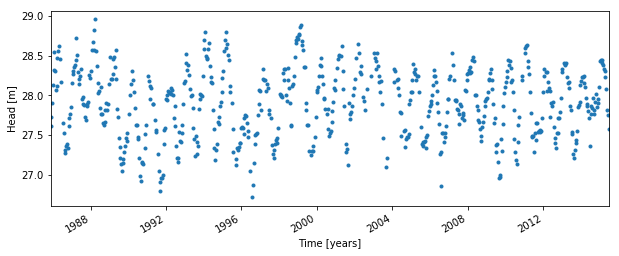

In [2]:
# Import groundwater time seriesm and squeeze to Series object
gwdata = pd.read_csv('../data/head_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
print('The data type of the oseries is: %s' %type(gwdata))

# Plot the observed groundwater levels
gwdata.plot(style='.', figsize=(10, 4))
plt.ylabel('Head [m]');
plt.xlabel('Time [years]');

### 2. Import the independent time series
Two explanatory series are used: the precipitation and the potential evaporation. These need to be `pandas Series` objects, as for the observed heads.

Important characteristics of these time series are:
- All series are stored as `pandas Series` objects.
- The series may have irregular time intervals, but then it will be converted to regular time intervals when creating the time series model later on.
- It is preferred to use the same length units as for the observed heads.

The data type of the precip series is: <class 'pandas.core.series.Series'>
The data type of the evap series is: <class 'pandas.core.series.Series'>
The data type of the recharge series is: <class 'pandas.core.series.Series'>


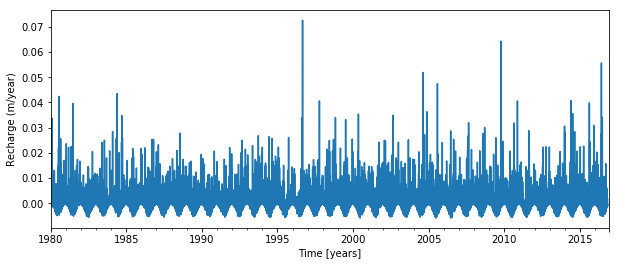

In [3]:
# Import observed precipitation series
precip = pd.read_csv('../data/rain_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
print('The data type of the precip series is: %s' %type(precip))

# Import observed evaporation series
evap = pd.read_csv('../data/evap_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
print('The data type of the evap series is: %s' %type(evap))

# Calculate the recharge to the groundwater
recharge = precip - evap
print('The data type of the recharge series is: %s' %type(recharge))

# Plot the time series of the precipitation and evaporation
plt.figure()
recharge.plot(label='Recharge', figsize=(10, 4))
plt.xlabel('Time [years]')
plt.ylabel('Recharge (m/year)');

### 3. Create the time series model
In this code block the actual time series model is created. First, an instance of the `Model` class is created (named `ml` here). Second, the different components of the time series model are created and added to the model. The imported time series are automatically checked for missing values and other inconsistencies. The keyword argument fillnan can be used to determine how missing values are handled. If any nan-values are found this will be reported by `pastas`.

In [4]:
# Create a model object by passing it the observed series
ml = ps.Model(gwdata)
# Add the recharge data as explanatory variable
ts1 = ps.StressModel(recharge, ps.Gamma, name='recharge', kind="evap")
ml.add_tseries(ts1)
# Add a noisemodel
n = ps.NoiseModel()
ml.add_noisemodel(n)

### 4. Solve the model
The next step is to compute the optimal model parameters. The default solver  uses a non-linear least squares method for the optimization. The python package `lmfit` is used (info on `lmfit` can be found [here](https://github.com/lmfit/lmfit-py)). Some standard optimization statistics are reported along with the optimized parameter values and correlations.

In [5]:
ml.solve()

[[Fit Statistics]]
    # function evals   = 39
    # data points      = 644
    # variables        = 5
    chi-square         = 4.144
    reduced chi-square = 0.006
    Akaike info crit   = -3239.652
    Bayesian info crit = -3217.313
[[Variables]]
    recharge_A:    726.162710 +/- 33.44861 (4.61%) (init= 2081.857)
    recharge_n:    1.05986521 +/- 0.014364 (1.36%) (init= 1)
    recharge_a:    129.292756 +/- 7.949492 (6.15%) (init= 100)
    constant_d:    27.5686989 +/- 0.020562 (0.07%) (init= 27.90008)
    noise_alpha:   60.0137199 +/- 8.059290 (13.43%) (init= 14)
[[Correlations]] (unreported correlations are <  0.100)
    C(recharge_A, recharge_a)    =  0.846 
    C(recharge_A, constant_d)    = -0.763 
    C(recharge_a, constant_d)    = -0.644 
    C(recharge_n, recharge_a)    = -0.619 
    C(recharge_A, recharge_n)    = -0.248 
    C(recharge_n, constant_d)    =  0.190 


### 5. Plot the results
The solution can be plotted after a solution has been obtained.

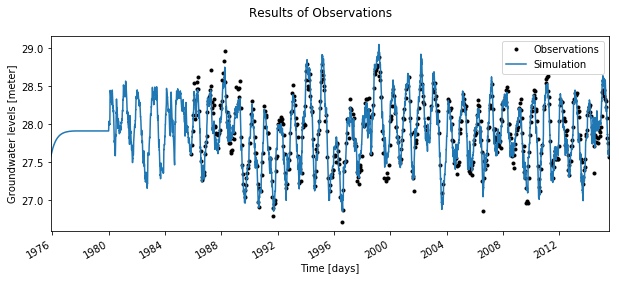

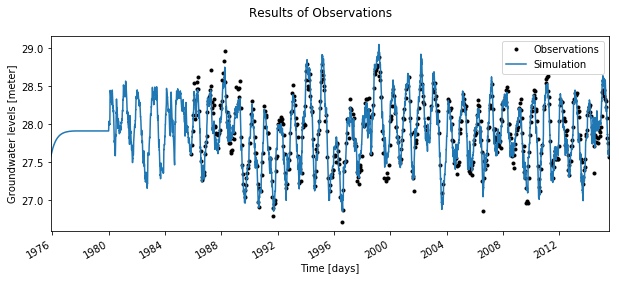

In [6]:
ml.plot(figsize=(10, 4))

### 6. Advanced plotting
There are many ways to further explore the time series model. `pastas` has some built-in functionalities that will provide the user with a quick overview of the model. The `plots` subpackage contains all the options. One of these is the method `plots.results` which provides a plot with more information.

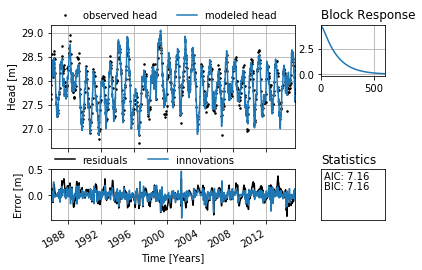

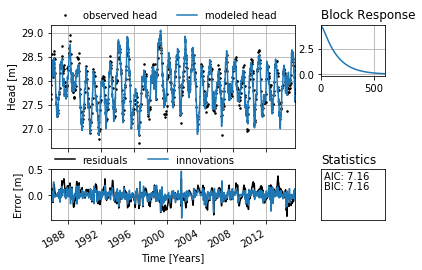

In [7]:
ml.plots.results()

### 7. Statistics
The `stats` subpackage includes a number of statistical functions that may applied to the model. One of them is the `summary` method, which gives a summary of the main statistics of the model.

In [8]:
ml.stats.summary()

,Value
Statistic,
Akaike Information Criterion,7.156040
Average Deviation,-0.001033
Bayesian Information Criterion,29.494533
Explained variance percentage,91.484937
Pearson R^2,0.956700
Root mean squared error,0.125428


### 8. Improvement: estimate evaporation factor
In the previous model, the recharge was estimated as precipitation minus potential evaporation. A better model is to estimate the actual evaporation as a factor (called the evaporation factor here) times the potential evaporation. First, new model is created (called `ml2` here so that the original model `ml` does not get overwritten). Second, the `StressModel2` object is created, which combines the precipitation and evaporation series and adds a parameter for the evaporation factor `f`. The `StressModel2` object is added to the model, the noise model is added, the model is solved, and the results and statistics are plotted to the screen. Note that the new model gives a better fit (lower root mean squared error and higher explained variance), and that the Akiake information criterion indicates that the addition of the additional parameter improved the model signficantly (the Akaike criterion for model `ml2` is higher than for model `ml`).

[[Fit Statistics]]
    # function evals   = 48
    # data points      = 644
    # variables        = 6
    chi-square         = 3.990
    reduced chi-square = 0.006
    Akaike info crit   = -3262.114
    Bayesian info crit = -3235.308
[[Variables]]
    rainevap_A:    670.244030 +/- 34.40857 (5.13%) (init= 2081.857)
    rainevap_n:    1.01602644 +/- 0.016513 (1.63%) (init= 1)
    rainevap_a:    148.806543 +/- 11.57697 (7.78%) (init= 100)
    rainevap_f:   -1.28878508 +/- 0.061782 (4.79%) (init=-1)
    constant_d:    27.9024648 +/- 0.067071 (0.24%) (init= 27.90008)
    noise_alpha:   49.9383257 +/- 6.431908 (12.88%) (init= 14)
[[Correlations]] (unreported correlations are <  0.100)
    C(rainevap_f, constant_d)    = -0.986 
    C(rainevap_n, rainevap_a)    = -0.700 
    C(rainevap_A, rainevap_a)    =  0.651 
    C(rainevap_n, rainevap_f)    =  0.540 
    C(rainevap_n, constant_d)    = -0.535 
    C(rainevap_a, constant_d)    =  0.411 
    C(rainevap_a, rainevap_f)    = -0.408 
    C(rain

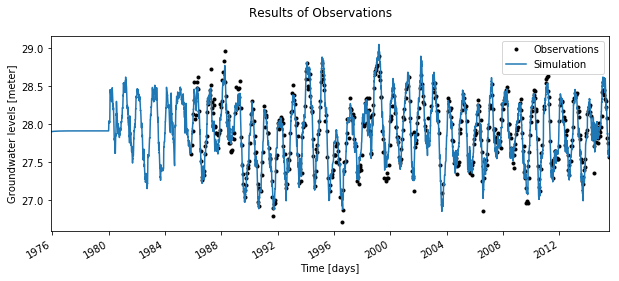

,Value
Statistic,
Akaike Information Criterion,9.231551
Average Deviation,-0.001418
Bayesian Information Criterion,36.037743
Explained variance percentage,92.995812
Pearson R^2,0.964702
Root mean squared error,0.113763


In [9]:
# Create a model object by passing it the observed series
ml2 = ps.Model(gwdata)

# Add the recharge data as explanatory variable
ts1 = ps.StressModel2([precip, evap], ps.Gamma, name='rainevap')
ml2.add_tseries(ts1)

# Add a noisemodel
n = ps.NoiseModel()
ml2.add_noisemodel(n)

# Solve the model
ml2.solve()

# Plot the results
ml2.plot(figsize=(10, 4))

# Statistics
ml2.stats.summary()

### Origin of the series
* The rainfall data is taken from rainfall station Heibloem in The Netherlands.
* The evaporation data is taken from weather station Maastricht in The Netherlands.
* The head data is well B58C0698, which was obtained from Dino loket